<a href="https://colab.research.google.com/github/fstrub95/RL/blob/master/AIMS_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning in Finite MDPs

In [0]:
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1
!cd mvarl_hands_on && git fetch

## MDPs

In [0]:
import sys
sys.path.insert(0, './mvarl_hands_on/utils')
import numpy as np
from scipy.special import softmax # for SARSA
import matplotlib.pyplot as plt
import json
import math
from test_env import ToyEnv1
from frozen_lake import FrozenLake
from cliffwalk import CliffWalk

Setting up the environment

In [0]:
# env = ToyEnv1(gamma=0.95)
# env = FrozenLake(gamma=0.95, deterministic=False, data_path="./mvarl_hands_on/data")
env = CliffWalk(proba_succ=0.98)

# Useful attributes
print("Set of states:", env.states)
print("Set of actions:", env.actions)
print("Number of states: ", env.Ns)
print("Number of actions: ", env.Na)
print("P has shape: ", env.P.shape)  # P[s'|s,a] = P[s, a, s'] = env.P[s, a, s']
print("R has shape: ", env.R.shape)  
print("discount factor: ", env.gamma)
print("")

# Usefult methods
state = env.reset() # get initial state
print("initial state: ", state)
print("reward at (s=1, a=3,s'=2): ", env.reward_func(1,3,2))
print("")

# A random policy
policy = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", policy)

# Interacting with the environment
print("(s, a, s', r):")
for time in range(4):
    action = policy[state]
    next_state, reward, done, info = env.step(action)
    print(state, action, next_state, reward)
    if done:
        break
    state = next_state
print("")


Set of states: range(0, 48)
Set of actions: [0, 1, 2, 3]
Number of states:  48
Number of actions:  4
P has shape:  (48, 4, 48)
R has shape:  (48, 4, 48)
discount factor:  0.99

initial state:  36
reward at (s=1, a=3,s'=2):  0.6

random policy =  [3 3 0 3 3 0 2 0 1 0 3 0 1 3 3 0 3 2 2 2 0 0 2 1 3 2 3 3 3 0 2 2 3 2 0 1 1
 1 1 0 1 2 0 0 1 0 3 1]
(s, a, s', r):
36 1 36 0.6
36 1 36 0.6
36 1 36 0.6
36 1 36 0.6



In [0]:
# def bellman_operator(Q, env):
#     TQ = np.zeros((env.Ns, env.Na))
#     greedy_policy = np.zeros(env.Ns)
#     for s in env.states:
#         for a in env.actions:
#             prob = env.P[s, a, :]
#             rewards = np.array([float(env.reward_func(s,a, s_)) for s_ in env.states])
#             TQ[s,a] = np.sum( prob*(rewards + env.gamma*Q.max(axis=1))  )

#     greedy_policy = np.argmax(TQ, axis = 1)
    
#     return TQ, greedy_policy
# def value_iteration(Q0, env, epsilon=1e-5):
#     """
#     Finding the optimal value function. To be done!
#     """
#     Q = Q0
#     while True:
#         TQ, greedy_policy = bellman_operator(Q, env)

#         err = np.abs(TQ-Q).max() 
#         if err < epsilon:
#             return TQ, greedy_policy

#         Q = TQ
# # --------------
# # Solution to 2.
# # --------------
# epsilon = 1e-14
# Q_opts = {}
# for env in [ToyEnv1(), FrozenLake(gamma=0.95, deterministic=False, data_path="./mvarl_hands_on/data"), CliffWalk(proba_succ=0.98)]:
#     Q0 = np.zeros((env.Ns, env.Na))

#     Q, greedy_policy = value_iteration(Q0, env, epsilon)
# #     err = np.abs(Q - bellman_operator(Q, env)[0]).max()
#     print(Q)
#     Q_opts["{}_{}".format(type(env).__name__,env.gamma)] = Q.tolist()
# #     print("norm of T(Q) - Q = ", err)
# #     assert err <= epsilon

# import json
# with open("./mvarl_hands_on/data/Q_opts.json", "w+") as fp:
#     json.dump(Q_opts, fp)


## Question 1: value iteration
1. Write a function applying the optimal Bellman operator on a provided Q function: $Q_1 = LQ_0, \; Q_0\in \mathbb{R}^{S\times A}$
2. Write a function implementing Value Iteration (VI) with $\infty$-norm stopping condition (reuse function implemented in 1)
3. Evaluate the convergence of your estimate, i.e., plot the value $\|V_n - V^\star\|_{\infty}$

In [0]:
# --------------
# Point 1
# --------------
def bellman_operator2(Q0, Ns, Na, R, P, gamma):
    Q1 = (R*P).sum(axis=2) + gamma * np.dot(P, np.max(Q0, axis=1))
    greedy_policy = np.argmax(Q1, axis=1)
    return Q1, greedy_policy

def bellman_operator(Q0, env, gamma):
    TQ = np.zeros((env.Ns, env.Na))
    for s in range(env.Ns):
        for a in range(env.Na):
            prob = env.P[s, a, :]
            rewards = np.array([float(env.reward_func(s,a, s_)) for s_ in env.states])
            TQ[s,a] = np.sum( prob*(rewards + gamma*Q0.max(axis=1)))
#     Qnp1, greedy_policy = bellman_operator2(Q0, env.Na, env.Na, env.R, env.P, env.gamma)
#     print(Qnp1)
#     print(TQ)
#     assert np.allclose(Qnp1, TQ)
    greedy_policy = np.argmax(TQ, axis=1)
    return TQ, greedy_policy

In [0]:
# --------------
# Point 2
# --------------
def value_iteration(Q0, env, gamma, epsilon=1e-5):
    S, A = env.Ns, env.Na
    R, P = env.R, env.P
    cond = True
    Qn = Q0
    Qfs = [Q0]
    while cond:
#         Qnp1, greedy_policy = bellman_operator(Qn, S, A, R, P, env.gamma)
        Qnp1, greedy_policy =   bellman_operator(Qn, env, gamma=gamma)
        cond = np.abs(Qnp1-Qn).max() > epsilon
#         print(np.abs(Qnp1-Qn).max())
        Qfs.append(Qnp1)
        Qn = Qnp1
    return Qn, greedy_policy, Qfs

Text(0.5, 1.0, 'Q-learning: Convergence of Q')

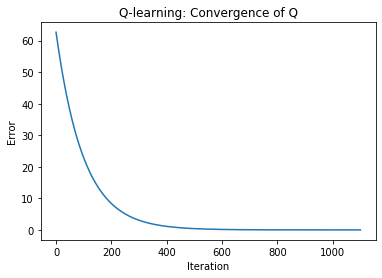

In [0]:
# --------------
# Point 3
# --------------
with open("./mvarl_hands_on/data/Q_opts.json", "r") as fp:
    Qopts = json.load(fp)
Qstar = Qopts["{}_{}".format(type(env).__name__,env.gamma)]

Q0 = np.zeros((env.Ns, env.Na))
Qn, greedy_policy, Qfs = value_iteration(Q0, env, gamma=env.gamma, epsilon=1e-5)
norm_values = [np.abs(el - Qstar).max() for el in Qfs]
plt.plot(norm_values)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Q-learning: Convergence of Q")

In [0]:
state = env.reset()
env.render()
for i in range(50):
    action = greedy_policy[state]
    state, reward, done, _ = env.step(action)
    env.render()

## Question 2: Q learning
Q learning is a model-free algorithm for estimating the optimal Q-function online.
It is an off-policy algorithm since the samples are collected with a policy that is (potentially) not the one associated to the estimated Q-function.

1. Implement Q learning with $\epsilon$-greedy exploration.
  - Plot the error in Q-functions over iterations
  - Plot the cumulative sum of rewards

In [0]:
# ---------------------------
# Q-Learning
# ---------------------------
# suggested interface
# you can change it!
class QLearning:
    """
    Q learning with epsilon-greedy exploration
    """
    def __init__(self, env, gamma, learning_rate, epsilon, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.Q = np.zeros((env.Ns, env.Na))
        self.Nsa = np.zeros((env.Ns, env.Na))
    
    def sample_action(self, state, greedy=False):
        epsilon = self.epsilon / max(1, math.sqrt(self.Nsa[state].min()))
        if not greedy and np.random.uniform(0, 1) < epsilon:
            # explore
            return np.random.choice(self.env.actions)
        else:
            # exploit
            b = self.Q[state, :]
            idxs = np.flatnonzero(np.isclose(b, b.max()))
            action = np.random.choice(idxs).item()
            return self.env.actions[action]
        
    
    def update(self, state, action, next_state, reward):
        alpha = self.learning_rate / max(1, math.sqrt(self.Nsa[state, action]))
        max_q = self.Q[next_state, :].max()
        q = self.Q[state, action]
        increment = reward + self.gamma*max_q - q
        
        # Update
        self.Q[state, action] = self.Q[state, action] + alpha*increment
        self.Nsa[state, action] += 1
        
    

optimal policy:  [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 3
 3 3 3 3 3 3 3 3 3 0 0]
est policy: [0 0 0 3 2 2 2 2 1 0 0 0 3 0 3 3 2 2 2 3 0 0 0 0 3 3 3 3 3 2 3 0 3 3 2 3 3
 0 3 3 2 3 2 0 3 2 2 0]


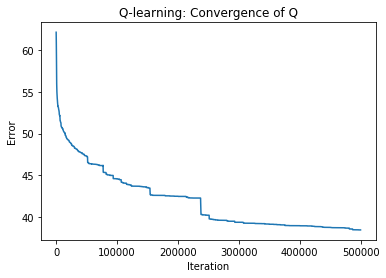

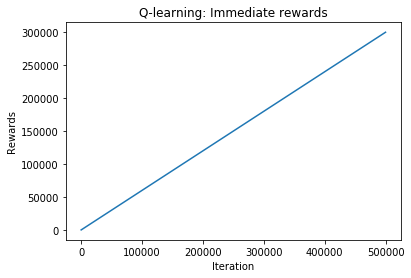

In [0]:
# --------------
# Point 1
# --------------
# Number of Q learning steps
max_steps = int(5e5)  

Q0 = np.zeros((env.Ns, env.Na))
# Use the previous code to verify the correctness of q learning
Q_opt, pi_opt, _ = value_iteration(Q0, env, gamma=env.gamma, epsilon=1e-8)

ql = QLearning(env, gamma=env.gamma, learning_rate=1., epsilon=0.6, min_epsilon=0.1)

# main algorithmic loop
norm_values = []
rewards = np.zeros((max_steps))
t = 0
state = env.reset()
while t < max_steps:
    action = ql.sample_action(state)
    observation, reward, done, info = env.step(action)
    rewards[t] = rewards[max(0,t-1)] + reward
    
    ql.update(state=state, action=action, next_state=observation, reward=reward)
    norm_values.append(np.abs(ql.Q - Q_opt).mean())
    
    state = observation
    if done:
        state = env.reset()
    
    # todo do something
    t = t + 1

plt.plot(norm_values)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Q-learning: Convergence of Q")

plt.figure()
plt.plot(rewards)
plt.xlabel('Iteration')
plt.ylabel('Rewards')
plt.title("Q-learning: Immediate rewards")

# print(env.render())
print("optimal policy: ", pi_opt)
greedy_policy_ql = np.argmax(ql.Q, axis=1)
print("est policy:", greedy_policy_ql)

# how confident are you in the performance of the algorithm? maybe a single run is not enough

In [0]:
state = env.reset()
env.render()
for i in range(50):
    action = greedy_policy_ql[state]
    state, reward, done, _ = env.step(action)
    env.render()

## Question 2: SARSA
SARSA is another control algorithm. While Qlearning is off-policy, SARSA is on-policy.

1. Implement SARSA with softmax (Gibbs) exploration and test the convergence to $Q^\star$
2. Evaluate the expected cumulative reward of the two algorithms: $t \mapsto \sum_{i=1}^t r_i$

In [0]:
# ---------------------------
# SARSA
# ---------------------------
# suggested interface
# you can change it!
class SARSA:
    """
    SARSA with SOFTMAX exploration
    """
    def __init__(self, env, gamma, learning_rate, temperature):
        self.env = env
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.temp = temperature
        self.Q = np.zeros((env.Ns, env.Na))
        self.Nsa = np.zeros((env.Ns, env.Na))
    
    def sample_action(self, state, greedy=False):
        # explore
        tau = self.temp / max(1, math.sqrt(self.Nsa[state].min()))
        val = self.Q[state, :]
        prob = softmax(val / tau)
        action = np.random.choice(self.env.actions, p=prob)
        return self.env.actions[action]
        
    def update(self, state, action, next_state, next_action, reward):
        alpha = self.learning_rate / max(1, math.sqrt(self.Nsa[state, action]))
        q_next = self.Q[next_state, next_action]
        q = self.Q[state, action]
        increment = reward + self.gamma*q_next - q
        
        # Update
        self.Q[state, action] = self.Q[state, action] + alpha*increment
        self.Nsa[state, action] += 1
    

+-----------------------+
| : : : : : : : : : : : |
| : : : :_: : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
None
optimal policy:  [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 3
 3 3 3 3 3 3 3 3 3 0 0]
est policy: [1 1 1 1 2 2 2 0 0 0 0 0 1 2 1 0 2 2 2 0 0 0 0 0 0 0 3 3 3 3 2 2 0 0 0 0 3
 0 3 2 2 3 0 0 0 0 0 0]


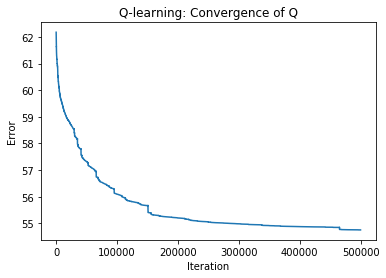

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


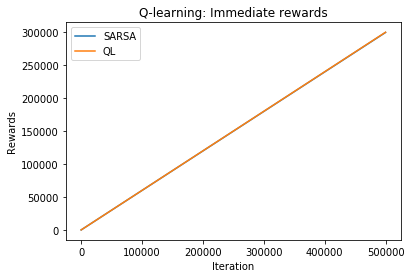

In [0]:
# --------------
# Point 1
# --------------

sarsa = SARSA(env, gamma=env.gamma, learning_rate=1., temperature=1.)

# main algorithmic loop
norm_values = []
rewards_SARSA = np.zeros((max_steps))
t = 0
state = env.reset()
action = sarsa.sample_action(state)
while t < max_steps:
    action = sarsa.sample_action(state)
    observation, reward, done, info = env.step(action)
    rewards_SARSA[t] = rewards_SARSA[max(0, t-1)] + reward
    next_action = sarsa.sample_action(observation)
    
    sarsa.update(state=state, action=action, 
                 next_state=observation, next_action=next_action, reward=reward)
    norm_values.append(np.abs(sarsa.Q - Q_opt).mean())
    
    state = observation
    if done:
        state = env.reset()
    
    # todo do something
    t = t + 1

plt.plot(norm_values)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Q-learning: Convergence of Q")

plt.figure()
plt.plot(rewards_SARSA, label="SARSA")
plt.plot(rewards, label="QL")
plt.xlabel('Iteration')
plt.ylabel('Rewards')
plt.title("Q-learning: Immediate rewards")
plt.legend()

print(env.render())
print("optimal policy: ", pi_opt)
greedy_policy_sarsa = np.argmax(sarsa.Q, axis=1)
print("est policy:", greedy_policy_sarsa)

# how confident are you in the performance of the algorithm? maybe a single run is not enough

In [0]:
state = env.reset()
env.render()
for i in range(50):
    action = greedy_policy_sarsa[state]
    state, reward, done, _ = env.step(action)
    env.render()

In [0]:

from gridworld import GridWorldWithPits
grid1 = [
    ['', '', '', 'g'],
    ['', 'x', '', ''],
    ['s', '', '', '']
]
grid1_MAP = [
    "+-------+",
    "| : : :G|",
    "| :x: : |",
    "|S: : : |",
    "+-------+",
]


env = GridWorldWithPits(grid=grid1, txt_map=grid1_MAP, uniform_trans_proba=0)